[Emo-DB dataset](https://www.kaggle.com/piyushagni5/berlin-database-of-emotional-speech-emodb)

It's foulder named `wav` should be in the same directory as this notebook

anger | boredom | disgust | anxiety/fear | happiness | sadness | neutral
--- | --- | --- | --- | --- | --- | ---
W | L | E | A | F | T | N 

# Loading data

In [129]:
import os
import numpy as np
        
def _load_emo_db(file_path):
    e2c = {'W': 0, 'L': 1, 'E': 2, 'A': 3, 'F': 4, 'T': 5, 'N': 6} #emotion code to class number
    code = lambda file_name: e2c[file_name.split('.')[0][-2:-1]] #get emotion code
    raw_data, labels = [], []
    for file_name in os.listdir(file_path):
        samplerate, data = wavfile.read(file_path+file_name)
        raw_data.append(data)
        labels.append(code(file_name))
    return raw_data, labels

class Dataset():
    '''class for dataset manipulation'''
    def __init__(self):
        self.raw_data = None
        self.data = None
        self.labels = None
        
    def load_data(self, file_path, load_function=_load_emo_db):
        self.raw_data, self.labels = load_function(file_path)
        return self.raw_data, self.labels
    
    def transform_data(self, sample_transform_function, *args, raw_data=False):
        if raw_data:
            data = self.raw_data
        else:
            data = self.data
        new_data = []
        for i, sample in enumerate(data):
            new_data.append(sample_transform_function(sample, *args))
            print(f"{i+1}/{len(data)}", end='\r')
        self.data = new_data
        print("Done!           ")
        return self.data
    
    def get_raw_data(self):
        return self.raw_data
    
    def get_data(self):
        return self.data
    
    def get_dataset(self):
        return self.data, self.labels

In [130]:
dataset = Dataset()
dataset.load_data('wav/');

# Preprocessing

### Wavelet transform

In [131]:
from scipy.io import wavfile
import pywt

def wavelet_transform(sample, lvl, wavelets):
    features = []
    for wvlt in wavelets:
        coeffs = pywt.wavedec(data, wvlt, level=lvl)
        features.append(coeffs)
    return features

In [132]:
dataset.transform_data(wavelet_transform, 10, ['db1', 'db6', 'db8', 'db10'], raw_data=True);

Done!           


# Feature extraction

### Statistical feature extraction

In [141]:
len(np.concatenate(dataset.get_data()[0][0]))

23040

In [182]:
import numpy as np
import scipy.stats

def zcr(data):
    count = 0
    positive_null = None
    for i in range(1, len(data)):
        if data[i-1]*data[i] < 0:
            count += 1
        elif data[i] == 0:
            if data[i-1] > 0:
                positive_null = True
            if data[i-1] < 0:
                positive_null = False
        elif data[i-1] == 0:
            if (data[i] > 0 and positive_null == False) or (data[i] < 0 and positive_null == True):
                count += 1
    return count

def wavelet_stat_features(wavelet_data):
    features = []
    features.append(max(wavelet_data))
    features.append(np.mean(wavelet_data))
    features.append(np.median(wavelet_data))
    features.append(scipy.stats.iqr(wavelet_data))
    features.append(np.std(wavelet_data))
    features.append(zcr(wavelet_data))
    features.append(scipy.stats.kurtosis(wavelet_data))
    features.append(scipy.stats.skew(wavelet_data))
    return features

def sample_stat_features(sample):
    stat_features = []
    for wavelet_data in sample:
        stat_features.append(wavelet_stat_features(np.concatenate(wavelet_data)))
    return np.concatenate(stat_features)

In [183]:
dataset.transform_data(wavelet_transform, 10, ['db1', 'db6', 'db8', 'db10'], raw_data=True);
dataset.transform_data(sample_stat_features);

Done!           
Done!           


In [189]:
stat_data, data_y = dataset.get_dataset()
stat_data = np.array(stat_data)
data_y = np.array(data_y)

# Model

### Simple Neural Network

In [190]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(stat_data, data_y, test_size=0.25, random_state=42)

In [191]:
X_train.shape

(401, 32)

In [192]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [193]:
print(X_test_scaled.shape, y_test.shape)

(134, 32) (134,)


In [194]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)

NameError: name 'torch' is not defined

In [33]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.transform = None
        self.target_transform = None
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
test_data = CustomDataset(X_test_tensor, y_test)
train_data = CustomDataset(X_train_tensor, y_train)

In [34]:
import torch
from torch.utils.data import DataLoader

batch_size = 32

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

for X, y in test_dataloader:
    print(X.shape, y.shape)

torch.Size([32, 32]) torch.Size([32])
torch.Size([32, 32]) torch.Size([32])
torch.Size([32, 32]) torch.Size([32])
torch.Size([32, 32]) torch.Size([32])
torch.Size([6, 32]) torch.Size([6])


In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [36]:
from torch import nn

class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32, 50),
            nn.ReLU(),
            nn.Linear(50, 7),
            nn.ReLU()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = net().to(device)
print(model)

net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=32, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=7, bias=True)
    (3): ReLU()
  )
)


In [45]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [46]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch%100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [47]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= size
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [48]:
from IPython.display import clear_output

epochs = 1000
for t in range(epochs):
    clear_output(wait=True)
    print(f"Epoch {t+1}\n----------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1000
----------------------------------
loss: 0.353693 [    0/  401]
Test Error: 
 Accuracy: 50.7%, Avg loss: 0.055713 

Done!


In [218]:
# for e_1 in range(7):
#     for e_2 in range(i, 7):
e_1, e_2 = 0, 1
feat_1 = np.array([stat_data[i] for i in range(len(stat_data)) if data_y[i] == e_1])
feat_2 = np.array([stat_data[i] for i in range(len(stat_data)) if data_y[i] == e_2])
p_values = []
for st in range(len(stat_data[0])):
    sample_1 = feat_1[:,st]
    sample_2 = feat_2[:,st]
    statistic, pvalue = scipy.stats.mannwhitneyu(sample_1, sample_2)
    p_values.append(pvalue)
print(p_values)

[3.2388894944876147e-17, 0.03302895764500591, 5.559332747769845e-23, 0.006343350301691576, 5.884860190908434e-19, 0.025015418714557505, 1.0619624139425507e-12, 0.3182844689842146, 1.4790386850380901e-21, 0.11922078908454009, 0.023797722320966292, 0.0053266496032277665, 4.764503222685756e-19, 0.09019715621234853, 5.754158769047299e-13, 0.005399368181869494, 9.81421439178209e-20, 0.28615960482381997, 0.3452846618510871, 0.007382196247441006, 4.377872936137043e-19, 0.1001883959106652, 2.1874648307592244e-12, 0.2298124332039485, 1.2065913352429607e-17, 0.45017751323424093, 0.24775117362575277, 0.008137941499067807, 4.377872936137043e-19, 0.10102128228596069, 3.7207945068277605e-12, 0.08981356316829614]


[2 8]


/home/phil/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/phil/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

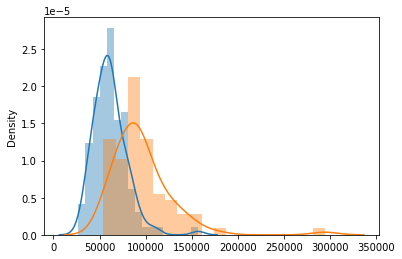

In [222]:
p_values = np.array(p_values)
k = 2
idx = np.argpartition(p_values, k)f"lvls = {lvls}")
print(idx[:k])
sns.distplot(feat_1[:,idx[2]])
sns.distplot(feat_2[:,idx[2]])

In [1]:
statistic, pvalue = scipy.stats.mannwhitneyu(feat_1[:,id], feat_2[:,id])
print(statistic, pvalue)

NameError: name 'scipy' is not defined